# A/B testing 
In this notebook, we'll use a dataset from Kaggle to analyse an A/B test result.
https://www.kaggle.com/datasets/zhangluyuan/ab-testing?select=ab_data.csv

This A/B test is designed to determine whether the company should change the 'Start Now' button from orange to pink on the homepage.
The current webpage has a conversion rate of 13%. If the new webpage can bring 2% rise in conversion rate,the company will launch the new webpage.

## An A/B test can be summarized into the 5 steps below:
1.Choose and characterize metrics to evaluate the experiment.

2.Choose significant level, statistical power, and practical signicicant level that you really want to launch the change if the test is statistically significant.

3.Calculated required sample size.

4.Take sample for control/treatment groups and run the test.

5.Analyze the results and draw conclusions.

The focus of this notebook is on Step 5.



# Load Dataset

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import math

In [2]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Step 1: Choose metrics

Control group: they'll be shown the old webpage with orange 'Start Now' button.

Treatment group: they'll be shown the new webpage with pink 'Start Now' button.
 
From the dataset, we can see a column named 'converted'. It has only 2 variables, 0 means not converted, and 1 means converted.
Thus, in this experiment, we will be calculating the conversion rate of control and treatment group based on the design.

We'll choose this test to be a two-sided test.

Null hypothesis: there is no difference between control group and treatment group in terms of converstion rate.
Alternative hypothesis:there is difference between control group and treatment group in terms of converstion rate.

Step 2: Choose significant level, statistical power, and practical signicicant level

The threshhold we set for the significant level is 95%. Statistical power is 0.8.
Practical signicicant level is 2% as we mentioned in the beginning.

Step 3: Calculated required sample size

Since we decided the significant leve, statisfical power, practical signiciant leve, we can easily get the sample size from the below website.

https://www.evanmiller.org/ab-testing/sample-size.html
    
The result is 4523 per each group.

Step 4: Take sample for control/treatment groups and run the test

In reality, we need to consider the duration,exposure,and effect of the test, and then run the test.

We need to consider questions like what's the best time to run it. We will also discuss questions like what fraction of traffic we want to expose the experiment to?


Step 5: Analyze the results and draw conclusions

Prepare the data for analysis


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [4]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

There are 294478 rows in the DataFrame, 5 columns and no null value. Next, we will check if any user is assigned to control and treatment group.  

In [5]:
session_counts=df['user_id'].value_counts()
multi_users=session_counts[session_counts>1].count()

In [6]:
print(f'There are {multi_users} users that were assinged multiple times in the dataset.')

There are 3894 users that were assinged multiple times in the dataset.


We will drop the above 3894 rows from the dataset.

In [7]:
users_to_drop=session_counts[session_counts>1].index

In [8]:
users_to_drop

Int64Index([805339, 754884, 722274, 783176, 898232, 899018, 904570, 842042,
            881123, 858720,
            ...
            721188, 902463, 713355, 827417, 655283, 847058, 889392, 664150,
            835401, 736955],
           dtype='int64', length=3894)

In [9]:
df=df[-df['user_id'].isin(users_to_drop)]

In [10]:
rows=df.shape
rows

(286690, 5)

The updataed dataset has 286690 entries.

Sampling

Now the DataFrame is ready, we can proceed and sample n=4523 entries for each group.

In [11]:
control_sample=df[df['group']=='control'].sample(n=4523,random_state=22)
treatment_sample=df[df['group']=='treatment'].sample(n=4523,random_state=22)

In [12]:
ab_test=pd.concat([control_sample,treatment_sample],axis=0)
ab_test.reset_index(drop=True,inplace=True)

In [13]:
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9041,915193,2017-01-19 17:04:52.129403,treatment,new_page,0
9042,774128,2017-01-20 00:38:59.462960,treatment,new_page,0
9043,814889,2017-01-03 23:54:27.136421,treatment,new_page,0
9044,742368,2017-01-23 02:17:23.490758,treatment,new_page,0


In [14]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9046 entries, 0 to 9045
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9046 non-null   int64 
 1   timestamp     9046 non-null   object
 2   group         9046 non-null   object
 3   landing_page  9046 non-null   object
 4   converted     9046 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 353.5+ KB


In [15]:
ab_test['group'].value_counts()

control      4523
treatment    4523
Name: group, dtype: int64

analyse the results

In [16]:
import seaborn as sns

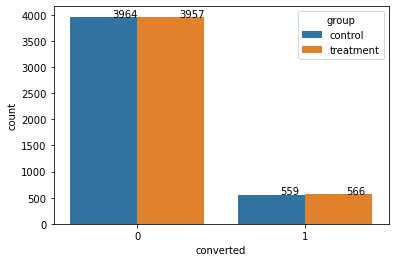

In [17]:
ax=sns.countplot(x='converted',hue='group',data=ab_test)
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

Conversion rate for control group is 12.4%.(559/4523=0.124)

Conversion rate for treatment group is 12.5%.(566/4523=0.125)

It seems that new webpage performed a little better, but didn't reach the practical signicicant level, which is 2%, as we expected.

check confidence interval

In [18]:
conversion_treatment = 0.125

conversion_control = 0.124

lower=(conversion_treatment-conversion_control)-1.96 * math.sqrt(conversion_treatment*
                                    (1-conversion_treatment)/4523+conversion_control *(1-conversion_control)/4523)
upper= (conversion_treatment-conversion_control)+1.96 * math.sqrt(conversion_treatment*
                        (1-conversion_treatment)/4523+conversion_control *(1-conversion_control)/4523)

In [19]:
print(f'{lower,upper}')

(-0.012607239479825838, 0.01460723947982584)


The confidence interval includes 0 in the middle, so we can't say the conversion rate of the treament group is different from the control group. This means that we can't reject our Null hypothesis, so we can't lauch our new webpage.